---
# Collocation Method for Harmonic Oscillator

The harmonic oscillator system of first-order differential equations:

$$
\begin{cases}
\frac{dx_1}{dt} = x_2 \\
\frac{dx_2}{dt} = -\omega^2 x_1
\end{cases}
$$

with initial conditions:

$$
x_1(0) = x_{1,0}, \quad x_2(0) = x_{2,0}
$$

can be discretized using the collocation method as follows.

---
## Discretization and Approximation

Choose $N$ collocation points $t_1, t_2, \ldots, t_N$ in $[0, T]$.

Approximate $x_1(t)$ and $x_2(t)$ by:

$$
x_1(t) \approx p_1(t) = \sum_{j=0}^{N} c_{1,j} \phi_j(t)
$$

$$
x_2(t) \approx p_2(t) = \sum_{j=0}^{N} c_{2,j} \phi_j(t)
$$


---
## Collocation Conditions

Recalling 
$
\begin{cases}
\frac{dx_1}{dt} = x_2 \\
\frac{dx_2}{dt} = -\omega^2 x_1
\end{cases}
$

At each collocation point $t_i$, we can obtain:

$$
\sum_{j=0}^{N} c_{1,j} \frac{d \phi_j(t_i)}{dt} = \sum_{j=0}^{N} c_{2,j} \phi_j(t_i)
$$

$$
\sum_{j=0}^{N} c_{2,j} \frac{d \phi_j(t_i)}{dt} = -\omega^2 \sum_{j=0}^{N} c_{1,j} \phi_j(t_i)
$$


---
## Initial Conditions

To solve for the coefficients $c_{1,j}$ and $c_{2,j}$:

$$
\sum_{j=0}^{N} c_{1,j} \phi_j(0) = x_{1,0}
$$

$$
\sum_{j=0}^{N} c_{2,j} \phi_j(0) = x_{2,0}
$$
---

In [76]:
import time

import jax.numpy as jnp
from jax import grad, jit
from jax.scipy.linalg import solve
import matplotlib.pyplot as plt

from interpolation import BarycentricInterpolation
from collocation import lagrange_basis, lagrange_derivative, lagrange_basis_node, compute_weights

#### Define the number of collocation points and the time interval

In [77]:
N = 10
omega = 5.0 # Angular frequency of the harmonic oscillator

T = 2
interpolator = BarycentricInterpolation(N, start = 0, stop = T)

collocation_points = interpolator.nodes

collocation_points

array([0.        , 0.06030738, 0.23395556, 0.5       , 0.82635182,
       1.17364818, 1.5       , 1.76604444, 1.93969262, 2.        ])

### Discretization and Collocation

In [78]:
phi = lagrange_basis_node(collocation_points)

weights = compute_weights(collocation_points)

dphi_dt = lagrange_derivative(collocation_points, weights)

### Initial Conditions

In [79]:
x1_0 = 1.0
x2_0 = 0.0

### Collocation Conditions

`CC.1` We approximate $ x_1(t) $ and $ x_2(t) $ using basis functions $ \phi_j(t) $

$$
x_1(t) \approx p_1(t) = \sum_{j=0}^{N} c_{1,j} \phi_j(t)
$$

$$
x_2(t) \approx p_2(t) = \sum_{j=0}^{N} c_{2,j} \phi_j(t)
$$

#### `CC.2` At each collocation point $ t_i $:

#### 1. Following $ \frac{dx_1}{dt} = x_2 $, we obtain:
$$
\sum_{j=0}^{N} c_{1,j} \frac{d \phi_j(t_i)}{dt} = \sum_{j=0}^{N} c_{2,j} \phi_j(t_i)
$$

#### 2. Following $ \frac{dx_2}{dt} = -\omega^2 x_1 $, we obtain:
$$
\sum_{j=0}^{N} c_{2,j} \frac{d \phi_j(t_i)}{dt} = -\omega^2 \sum_{j=0}^{N} c_{1,j} \phi_j(t_i)
$$


`CC.3` Matrix Representation

To form a system of equations, we organize the terms involving the coefficients $ c_{1,j} $ and $ c_{2,j} $ into matrix form.

- Let $ dphi\_dt $ be the matrix of the derivatives of the basis functions evaluated at the collocation points.
- Let $ phi $ be the matrix of the basis functions evaluated at the collocation points.
$$

---
### For the `first collocation condition` $ \frac{dx_1}{dt} = x_2 $:

$$
dphi\_dt \cdot \mathbf{c_1} = phi \cdot \mathbf{c_2}
$$

This can be written in block matrix form as:
$$
[dphi\_dt \quad -phi] \cdot \begin{bmatrix} \mathbf{c_1} \\ \mathbf{c_2} \end{bmatrix} = \mathbf{0}
$$

---
### For `the second collocation condition` $ \frac{dx_2}{dt} = -\omega^2 x_1 $:

$$
dphi\_dt \cdot \mathbf{c_2} = -\omega^2 \cdot phi \cdot \mathbf{c_1}
$$

This can be written in block matrix form as:
$$
[\omega^2 \cdot phi \quad dphi\_dt] \cdot \begin{bmatrix} \mathbf{c_1} \\ \mathbf{c_2} \end{bmatrix} = \mathbf{0}
$$
---

`CC.4` Constructing the Matrix $ A $

Combining these two sets of equations, we form the block matrix $ A $:

$$
A = \begin{bmatrix}
dphi\_dt & -phi \\
\omega^2 \cdot phi & dphi\_dt
\end{bmatrix}
$$

`CC.5`
The complete linear system we need to solve is:

$$
A \cdot \begin{bmatrix} \mathbf{c_1} \\ \mathbf{c_2} \end{bmatrix} = \mathbf{b},
$$

where $b$ is **0** for each `collocation condition` part.


In [80]:
A = jnp.block([
    [dphi_dt, -phi],
    [omega**2 * phi, dphi_dt]
])

A.shape

(20, 20)

The shape is $N$ x $N$

`CC.6` Initial Conditions + Collocation Conditions

* The initial + collocation conditions are represented by vector *b*
* The full shape is expected to be $(N + 1) * 2$ 

Initial Conditions Matrix:

$$
I_{x1} = \begin{bmatrix} 
\phi_j(0) 
\end{bmatrix}_{j=0}^{N} \quad \text{and zeros for } c_{2,j}
$$

$$
I_{x2} = \text{zeros for } c_{1,j} \quad \begin{bmatrix} 
\phi_j(0) 
\end{bmatrix}_{j=0}^{N}
$$


Right-Hand Side Vector $b_{\text{aug}}$:

$$
b_{\text{aug}} = \begin{bmatrix} 
0 \\ 
\vdots \\ 
0 \\ 
x_{1,0} \\ 
x_{2,0} 
\end{bmatrix}
$$

In [81]:
b = jnp.zeros(2 * (N))

b_aug = jnp.concatenate([b, jnp.array([x1_0, x2_0])])

b_aug.shape

b_aug

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0.], dtype=float64)

Augmented Matrix $A_{\text{aug}}$:

$$
A_{\text{aug}} = \begin{bmatrix} 
A \\ 
I_{x1} \\ 
I_{x2} 
\end{bmatrix}
$$

In [82]:
I_x1 = jnp.zeros((1, 2 * (N)))
I_x1 = I_x1.at[0, :N].set(phi[0, :])

I_x2 = jnp.zeros((1, 2 * (N)))
I_x2 = I_x2.at[0, N:].set(phi[0, :])

# Augment A with initial conditions
A_aug = jnp.vstack([A, I_x1, I_x2])

A_aug.shape

(22, 20)

#### `CC.7` Solve

The original system is given by:

$$ A c = b $$

To solve this system using the normal equations, we transform it into:

$$ A^T A c = A^T b $$

In [83]:
c = solve(A_aug.T @ A_aug, A_aug.T @ b_aug)

`CC.8` Extract Coefficients

In [84]:
c1 = c[:N]
c2 = c[N:2*(N)]

# print(c1.shape)
print("C1:\n", c1)
print("C2:\n", c2)

C1:
 [ 0.93184148  0.89258076  0.36310525 -0.75411344 -0.48689215  0.81270148
  0.34633024 -0.75210016 -0.89142444 -0.78069995]
C2:
 [-2.99492250e-03 -1.38668161e+00 -4.31502481e+00 -2.73411305e+00
  3.80914242e+00  1.89119417e+00 -4.23654110e+00 -2.67663463e+00
  1.14750935e+00  2.41558896e+00]


In [85]:
display(lagrange_basis)

<function collocation.lagrange_basis(xi, x)>

In [86]:
# alternative definitions for lagrange basis

def lagrange_basis_(j, t, points):
    terms = [(t - points[m]) / (points[j] - points[m]) for m in range(len(points)) if m != j]
    return jnp.prod(jnp.array(terms))

def lagrange_basis_matrix(points, t_test):
    N = len(points) - 1
    return jnp.array([[lagrange_basis_(j, t, points) for j in range(N + 1)] for t in t_test])

In [87]:
t_test = jnp.linspace(0, T, 100)
lb = lagrange_basis_matrix(collocation_points, t_test)

x1_test = lb @ c1
x2_test = lb @ c2

In [88]:
lb.shape

(100, 10)

x1_test shape: (100,)
x2_test shape: (100,)


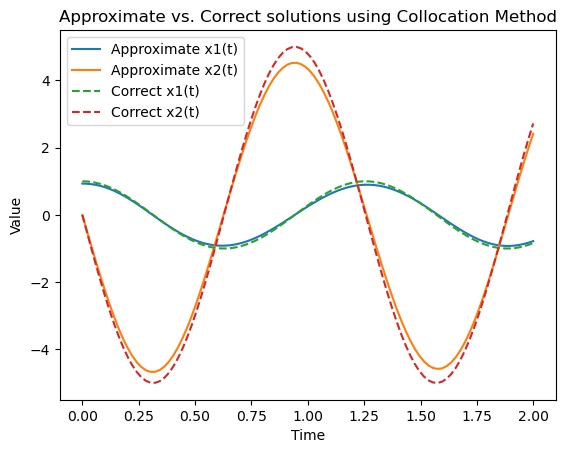

In [89]:
x1_correct = x1_0 * jnp.cos(omega * t_test) + (x2_0 / omega) * jnp.sin(omega * t_test)
x2_correct = x2_0 * jnp.cos(omega * t_test) - x1_0 * omega * jnp.sin(omega * t_test)

print("x1_test shape:", x1_test.shape)
print("x2_test shape:", x2_test.shape)

plt.plot(t_test, x1_test, label='Approximate x1(t)')
plt.plot(t_test, x2_test, label='Approximate x2(t)')
plt.plot(t_test, x1_correct, '--', label='Correct x1(t)')
plt.plot(t_test, x2_correct, '--', label='Correct x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.show()

* equally spaced, improvement follows

### Complete Script for Collocation

In [90]:
N = 20
omega = 2.0 
T = 10

interpolator = BarycentricInterpolation(N, start=0, stop=T)
collocation_points = interpolator.nodes

phi = lagrange_basis_node(collocation_points)
weights = compute_weights(collocation_points)
dphi_dt = lagrange_derivative(collocation_points, weights)

x1_0 = 1.0
x2_0 = 0.0

# Form the collocation matrix A
# This part will have to be modified for each ODE defintion
A = jnp.block([
    [dphi_dt, -phi],       # First collocation condition: dx1/dt = x2
    [omega**2 * phi, dphi_dt]  # Second collocation condition: dx2/dt = -omega^2 * x1
])

b = jnp.zeros(2 * (N))
b_aug = jnp.concatenate([b, jnp.array([x1_0, x2_0])])

I_x1 = jnp.zeros((1, 2 * (N)))
I_x1 = I_x1.at[0, :N].set(phi[0, :])

I_x2 = jnp.zeros((1, 2 * (N)))
I_x2 = I_x2.at[0, N:].set(phi[0, :])

A_aug = jnp.vstack([A, I_x1, I_x2])

# Solve the linear system using the normal equations
# A^T A c = A^T b
c = solve(A_aug.T @ A_aug, A_aug.T @ b_aug)

c1 = c[:N]
c2 = c[N:]

In [91]:
# Test the approximations
t_test = jnp.linspace(0, T, 100)
lb = jnp.transpose(lagrange_basis(collocation_points, t_test))


In [92]:
lb.shape

(100, 20)

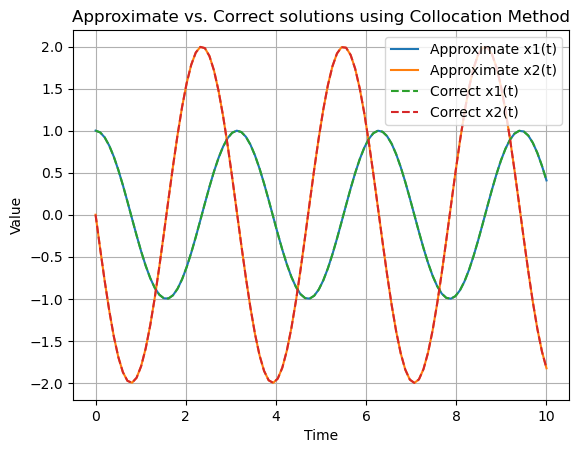

In [93]:
x1_test = lb @ c1
x2_test = lb @ c2

# Compute the correct solutions
x1_correct = x1_0 * jnp.cos(omega * t_test) + (x2_0 / omega) * jnp.sin(omega * t_test)
x2_correct = x2_0 * jnp.cos(omega * t_test) - x1_0 * omega * jnp.sin(omega * t_test)

plt.plot(t_test, x1_test, label='Approximate x1(t)')
plt.plot(t_test, x2_test, label='Approximate x2(t)')
plt.plot(t_test, x1_correct, '--', label='Correct x1(t)')
plt.plot(t_test, x2_correct, '--', label='Correct x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.grid(True)
plt.show()

### Can it be also solved as an optimization problem?

In [19]:
from jax.scipy.optimize import minimize

In [20]:
def objective(c, A, b):
    residuals = A @ c - b
    return jnp.sum(residuals**2)

# Initial guess for c
initial_c = jnp.zeros(A_aug.shape[1])

# Solve the optimization problem
result = minimize(objective, initial_c, args=(A_aug, b_aug), method='BFGS')
c_opt = result.x

In [21]:
c1 = c_opt[:N]
c2 = c_opt[N:]

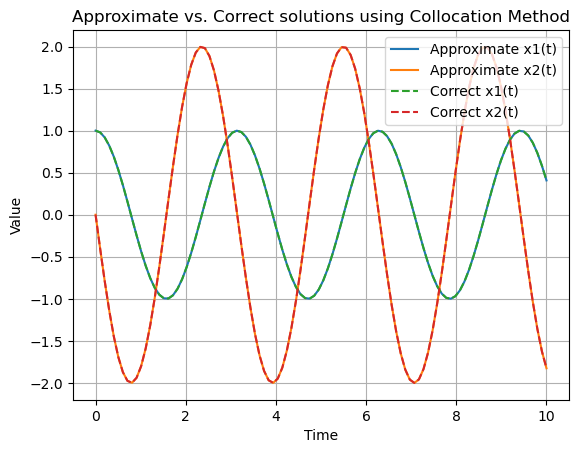

In [22]:
t_test = jnp.linspace(0, T, 100)
lb = jnp.transpose(lagrange_basis(collocation_points, t_test))

x1_test = lb @ c1
x2_test = lb @ c2

# correct solutions
x1_correct = x1_0 * jnp.cos(omega * t_test) + (x2_0 / omega) * jnp.sin(omega * t_test)
x2_correct = x2_0 * jnp.cos(omega * t_test) - x1_0 * omega * jnp.sin(omega * t_test)

plt.plot(t_test, x1_test, label='Approximate x1(t)')
plt.plot(t_test, x2_test, label='Approximate x2(t)')
plt.plot(t_test, x1_correct, '--', label='Correct x1(t)')
plt.plot(t_test, x2_correct, '--', label='Correct x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.grid(True)
plt.show()

Optimization also works

In [71]:
from collocation_improved import collocation_ode_solver

def harmonic_oscillator_system(dphi_dt, phi, params):
    omega = params.get('omega', 1.0)
    return jnp.block([
        [dphi_dt, -phi],
        [omega**2 * phi, dphi_dt]
    ])

Elapsed time: 0.8846509456634521


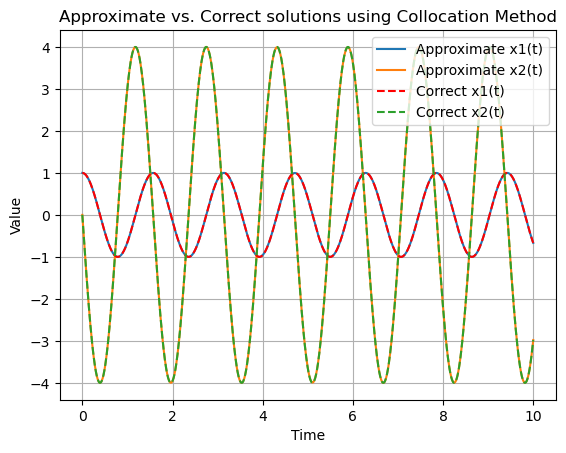

In [75]:
t_span = (0, 10)
t_= jnp.linspace(t_span[0], t_span[1], 1000)
N = 30
omega = 4.0
initial_conditions = (1.0, 0.0)  # x1_0, x2_0
params = {'omega': omega}

start = time.time()
x = collocation_ode_solver(harmonic_oscillator_system, initial_conditions, t_, N, "Chebyshev_local_32", params)
stop = time.time()
print("Elapsed time:", stop - start)

x1, x2 = jnp.transpose(x)[0], jnp.transpose(x)[1]

# Compute the correct solutions
x1_correct = x1_0 * jnp.cos(omega * t_) + (x2_0 / omega) * jnp.sin(omega * t_)
x2_correct = x2_0 * jnp.cos(omega * t_) - x1_0 * omega * jnp.sin(omega * t_)

plt.plot(t_, x1, label='Approximate x1(t)')
plt.plot(t_, x2, label='Approximate x2(t)')
plt.plot(t_, x1_correct, 'r--', label='Correct x1(t)')
plt.plot(t_, x2_correct, '--', label='Correct x2(t)')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Approximate vs. Correct solutions using Collocation Method')
plt.grid(True)
plt.show()

In [33]:
def damped_oscillator_system(dphi_dt, phi, params):
    """
    Constructs the collocation matrix for a damped oscillator system.
    
    Args:
    - dphi_dt: Matrix of derivatives of the polynomial basis functions at the collocation points.
    - phi: Matrix of the polynomial basis functions at the collocation points.
    - params: Dictionary containing the parameters 'omega_0' (natural frequency) and 'zeta' (damping ratio).

    Returns:
    - A: The augmented system matrix for the collocation points.
    """
    omega_0 = params.get('omega_0', 1.0)  # Natural frequency of the oscillator
    zeta = params.get('zeta', 0.1)       # Damping ratio

    # Setup the system of equations based on:
    # dx1/dt = x2
    # dx1/dt - x2 = 0
    
    # dx2/dt = -2*zeta*omega_0*x2 - omega_0**2*x1
    # (omega_0**2*x1) + (dx2/dt + 2*zeta*omega_0*x2) = 0
    return jnp.block([
        [dphi_dt, -phi],                      
        [omega_0**2 * phi, dphi_dt + 2 * zeta * omega_0 * phi] 
    ])

In [34]:
params = {'omega_0': 2.0,  # Natural frequency
          'zeta': 0.1}    # Damping ratio

initial_conditions = (1.0, 0.0)  
# x1_0 (initial displacement), x2_0 (initial velocity)

t_span = (0, 10)
t_= jnp.linspace(t_span[0], t_span[1], 400)

N = 20 

In [43]:
x = collocation_ode_solver(damped_oscillator_system, initial_conditions, t_, N, "Chebyshev_local", params)

x1, x2 = jnp.transpose(x)[0], jnp.transpose(x)[1]

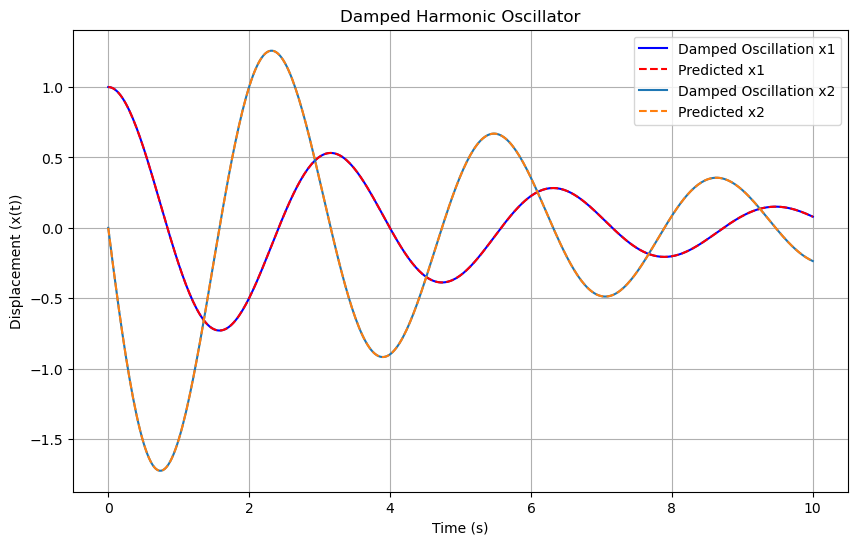

In [44]:
import numpy as np
import matplotlib.pyplot as plt

omega_0 = params['omega_0']  # natural frequency
zeta = params['zeta']    # damping ratio
omega_d = omega_0 * np.sqrt(1 - zeta**2)  # damped natural frequency

x0 = 1.0  # initial displacement
v0 = 0.0  # initial velocity

# ANALYTICAL SOLUTION for underdamped oscillator
A = x0
B = (v0 + zeta * omega_0 * x0) / omega_d
x_t = np.exp(-zeta * omega_0 * t_) * (A * np.cos(omega_d * t_) + B * np.sin(omega_d * t_))
x2_t = np.exp(-zeta * omega_0 * t_) * (omega_d * (B * np.cos(omega_d * t_) - A * np.sin(omega_d * t_)) - zeta * omega_0 * (A * np.cos(omega_d * t_) + B * np.sin(omega_d * t_)))

plt.figure(figsize=(10, 6))
plt.plot(t_, x_t, label='Damped Oscillation x1', color='blue')
plt.plot(t_, x1, label='Predicted x1', color='red', linestyle='--')
plt.plot(t_, x2_t, label='Damped Oscillation x2')
plt.plot(t_, x2, label='Predicted x2', linestyle='--')
plt.title('Damped Harmonic Oscillator')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (x(t))')
plt.grid(True)
plt.legend()
plt.show()